### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 6
### Due: Saturday, Mar 23rd at 11.59pm CT
---

This problem has to do with density estimation and clustering. 

1. Read in `hw6_data_1.npy`. The dataset should consist of $1000$ samples with $2$ features. Note that the last column are the labels, not another feature. Make a $2$-D scatter plot of the data colored by their labels. 


2. Start with kernel density estimation on the data set. First, perform a grid search $5$-fold cross-validation to find the best bandwidth, testing $30$ bandwidths between $0.1$ and $1.0$. What is this best bandwidth? Using this best bandwidth, plot the two-dimensional kernel density estimate of the distribution. 


3. Now try a nearest neighbors approach to estimating the density. Use the Bayesian nearest neighbors option. Plot the estimated distribution. What value of $k$ neighbors do you need to make the plot look similar to your KDE distribution?


4. Now fit a Gaussian mixture model. Compute the AIC and BIC for the number of GMM components between $1$ and $10$. Plot these AIC and BIC values as a function of number of components. What is the optimal number according to the BIC? Fit the data set with this optimal number of GMM components, and create a new plot that shows the data set, the GMM component mean locations, and the $2$-sigma GMM component ellipses. *(Use the code below to help with plotting the ellipses.)*

5. Now try Kmeans clustering with $5$ clusters. 
    - Use the `StandardScalar` to scale the data.
    - Fit the Kmeans model.
    - Find the cluster centers, and then inverse transform thse cluster centers back to the original unscaled coordinates.
    - Predict the labels for the scaled data.
    - Finally, make a two-panel side by side plot showing (a) the original data colored by its labels, then (b) the data colored by the Kmeans predicted labels, with cluster centers superposed.

### Solution

#### 1.1

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm

import scipy
import swiftascmaps

In [2]:
#read in hw6 data
hw6_data = np.load('/Users/toralcm/repos/astr_8070_s24/coursework/homeworks/hw_data/hw6_data_1.npy');

In [3]:
hw6_data

array([[-8.46474567, -3.45517123,  1.        ],
       [-9.93233853, -2.31955228,  1.        ],
       [-9.30833095, -1.9725388 ,  1.        ],
       ...,
       [-3.42236789,  1.69166315,  2.        ],
       [-3.31992823, -6.1090681 ,  3.        ],
       [-3.62495834,  0.11710104,  2.        ]])

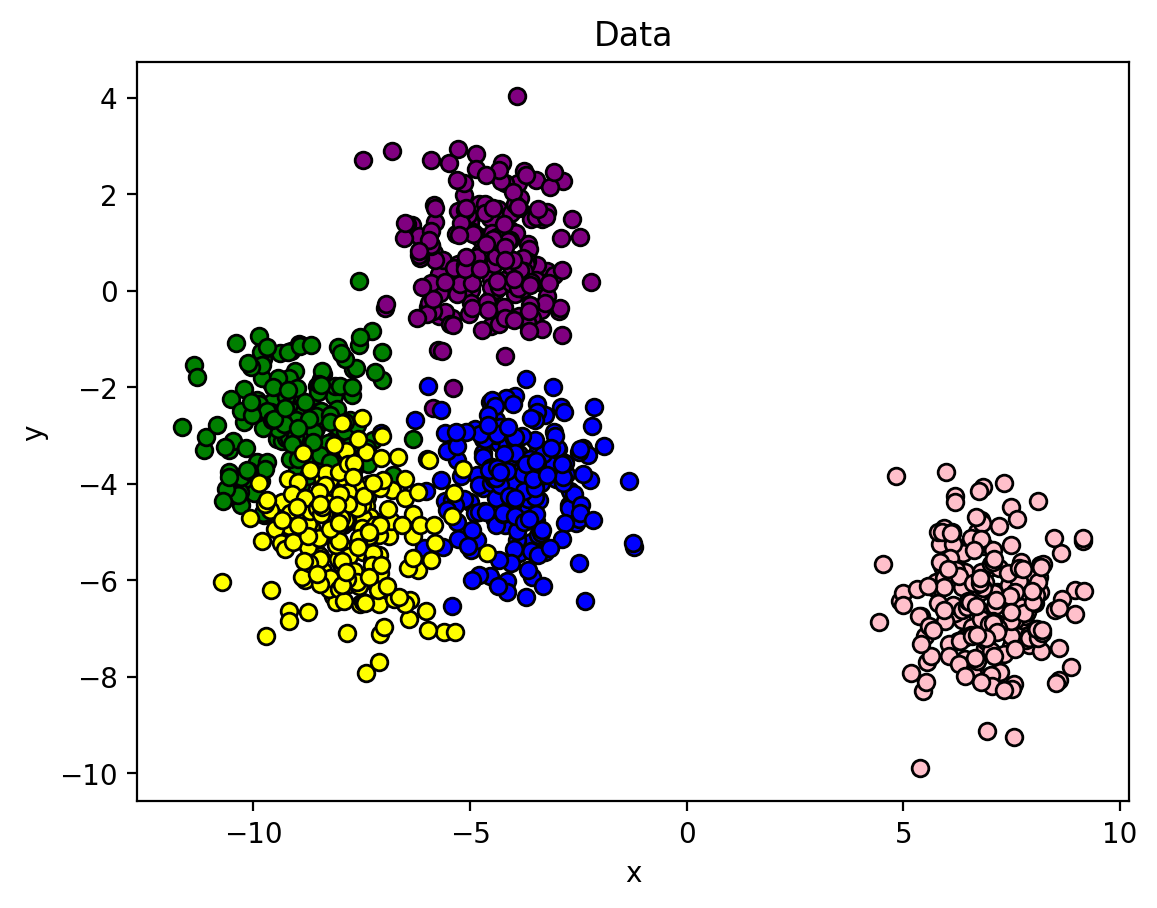

In [4]:
#scatter plot
labels=hw6_data[:,2]

colors = ['pink','green','purple','blue','yellow']
for ii in range(5):
    plt.scatter(hw6_data[labels==ii,0],hw6_data[labels==ii,1],c=colors[ii], edgecolor='black')

plt.title('Data')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

#### 1.2

In [5]:
#KDE -- from lecture 14

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV


#30 bandwidths between 0.1 and 1.0
bandwidths = np.linspace(0.1, 1.0, 30)

K=5 #number of folds 
grid = GridSearchCV(KernelDensity(), {'bandwidth': bandwidths}, cv=K) 
grid.fit(hw6_data[:,0:2])
opt = grid.best_params_['bandwidth']

print(opt)


0.4724137931034482


In [6]:
x = y = np.linspace(-12,12,100)
grid = np.vstack(list(map(np.ravel, np.meshgrid(x, y)))).T
print(grid.shape)

(10000, 2)


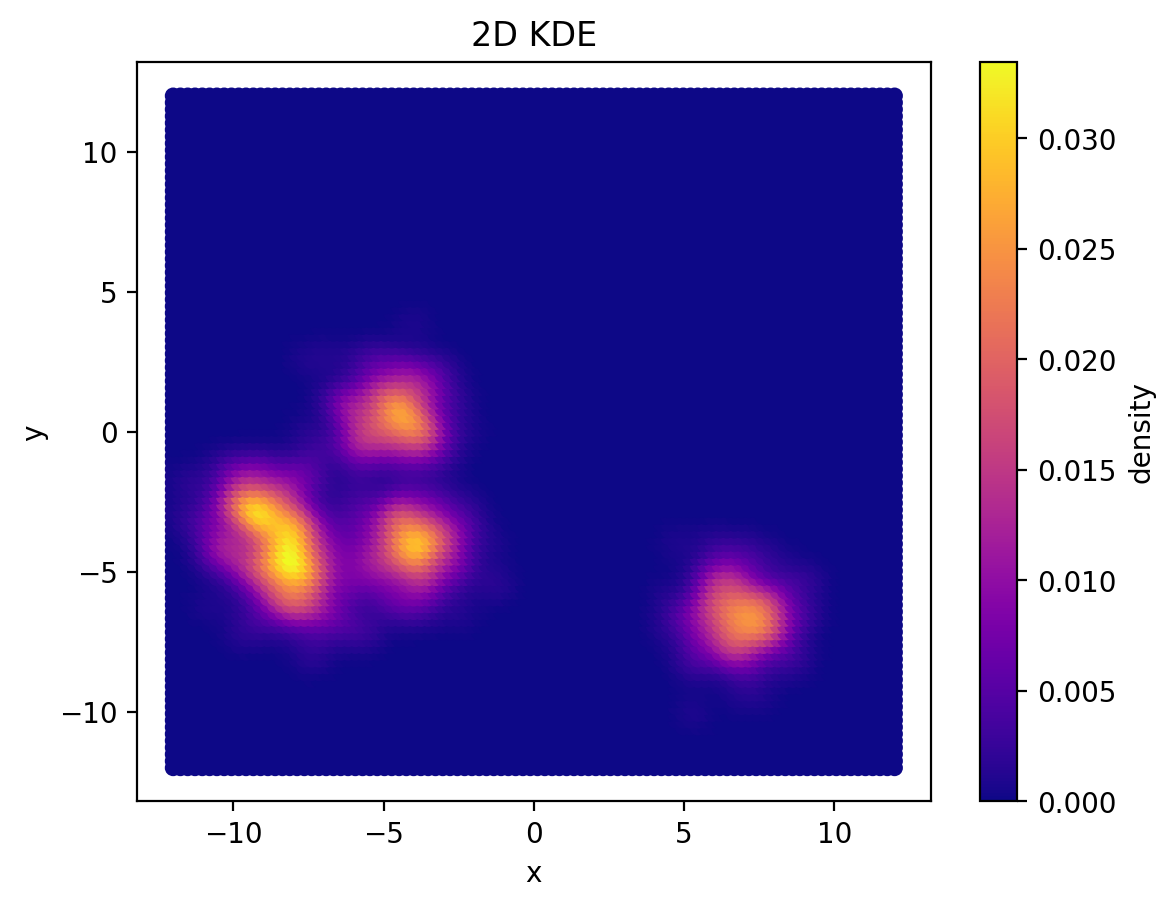

In [7]:
#plot kernel density 
from sklearn.neighbors import KernelDensity

#fit optimal bandwidth to the data
kde = KernelDensity(bandwidth=opt)
kde.fit(hw6_data[:,0:2]) #only fit first 2 columns(x features, y=labels)

x = y = np.linspace(-12,12,100)
grid = np.vstack(list(map(np.ravel, np.meshgrid(x, y)))).T
dens = np.exp(kde.score_samples(grid))


plt.scatter(grid[:,0], grid[:,1], c=dens, 
            cmap="plasma", edgecolor="None")
plt.colorbar(label='density')

plt.xlabel('x')
plt.ylabel('y')
plt.title('2D KDE')
plt.show()

#### 1.3

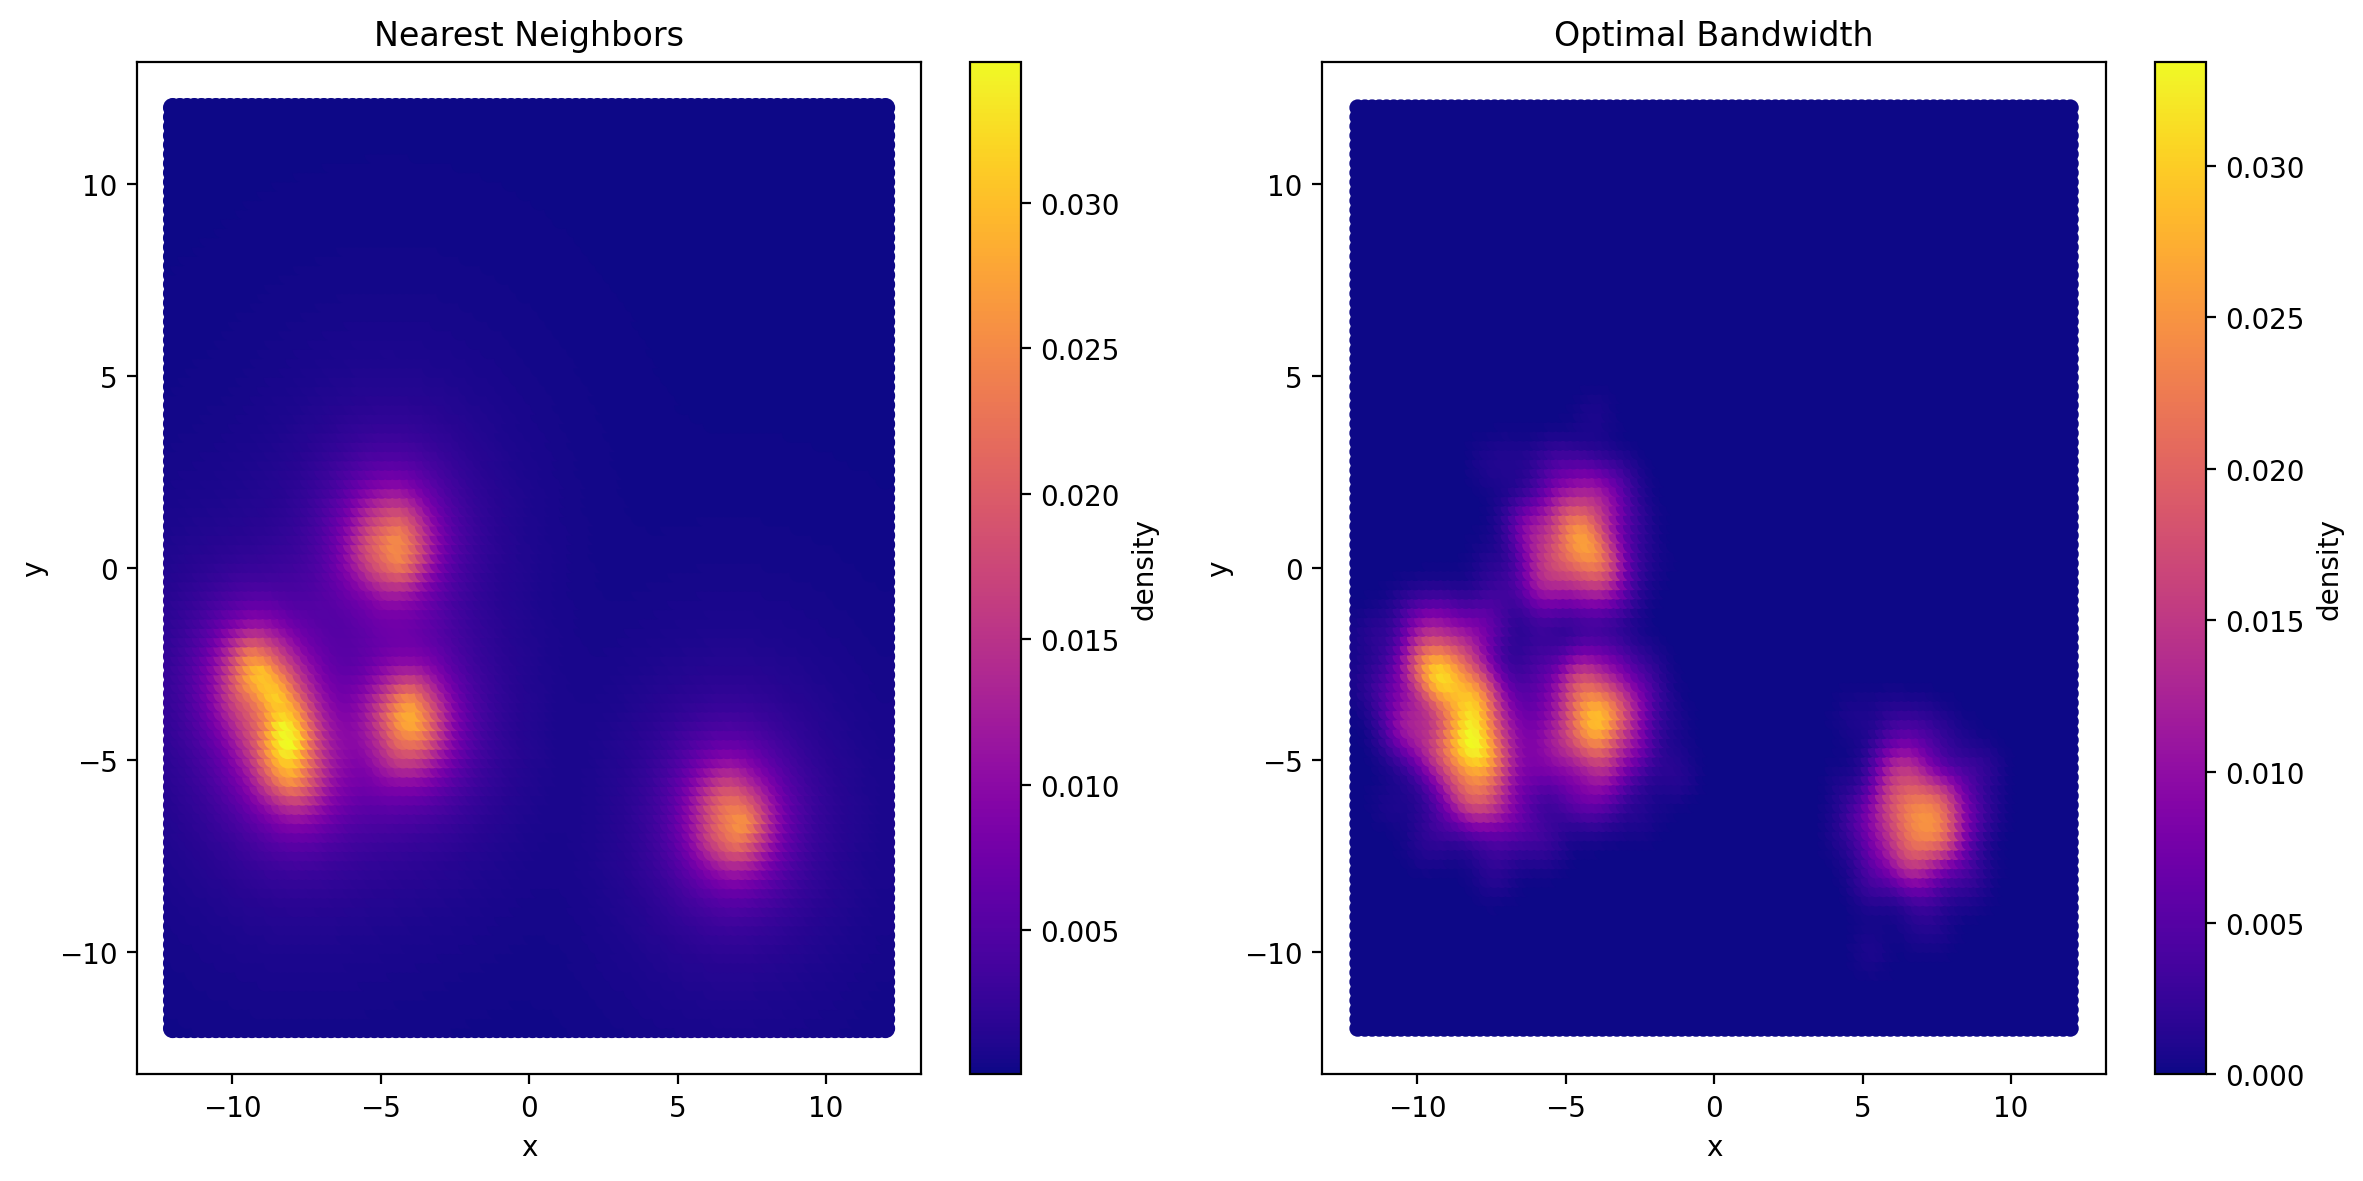

In [8]:
#nearest neighbors 
from astroML.density_estimation import KNeighborsDensity
from astropy.visualization import hist
from sklearn.neighbors import KernelDensity


x12 = hw6_data[:,0:2]

N = len(hw6_data)#number of data points
x = y = np.linspace(-12,12,100)
grid = np.vstack(list(map(np.ravel, np.meshgrid(x, y)))).T
dens = np.exp(kde.score_samples(grid))

# Compute density with Bayesian nearest neighbors
k_neighbors = 100
nbrs = KNeighborsDensity('bayesian', n_neighbors=k_neighbors)
nbrs.fit(x12)
dens_nbrs = nbrs.eval(grid) / N

#plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

scatter_neighbors = ax1.scatter(grid[:,0],grid[:,1], c=dens_nbrs, cmap="plasma", label="Nearest Neighbors (k=%i)" % k_neighbors)

scatter_bandwidth= ax2.scatter(grid[:,0], grid[:,1], c=dens, 
            cmap="plasma", edgecolor="None")

ax1.set_title('Nearest Neighbors')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
fig.colorbar(scatter_neighbors, ax=ax1, label='density')


ax2.set_title('Optimal Bandwidth')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
fig.colorbar(scatter_bandwidth, ax=ax2, label='density')




plt.tight_layout()

plt.show()

#### 1.4

/Users/toralcm/anaconda3/envs/astr8070/lib/python3.11/site-packages/astroML/linear_model/linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


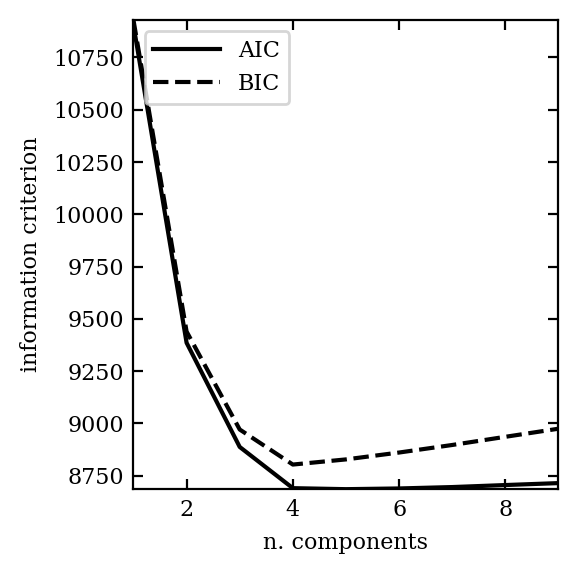

In [9]:
#gaussian mixture model 
from sklearn.mixture import GaussianMixture


if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

#GMM components
gm = np.arange(1, 10)
models = [None for i in range(len(gm))]

for i in range(len(gm)):
    models[i] = GaussianMixture(gm[i]).fit(x12)

#AIC and BIC
AIC = [m.aic(x12) for m in models]
BIC = [m.bic(x12) for m in models]

#plot AIC and BIC as a function of the number of components
fig = plt.figure(figsize=(10, 3.4))
fig.subplots_adjust(left=0.12, right=0.97,
                    bottom=0.21, top=0.9, wspace=0.5)
ax = fig.add_subplot(132)
ax.plot(gm, AIC, '-k', label='AIC')
ax.plot(gm, BIC, '--k', label='BIC')
ax.set_xlabel('n. components')
ax.set_ylabel('information criterion')
ax.legend(loc=2)

plt.show()


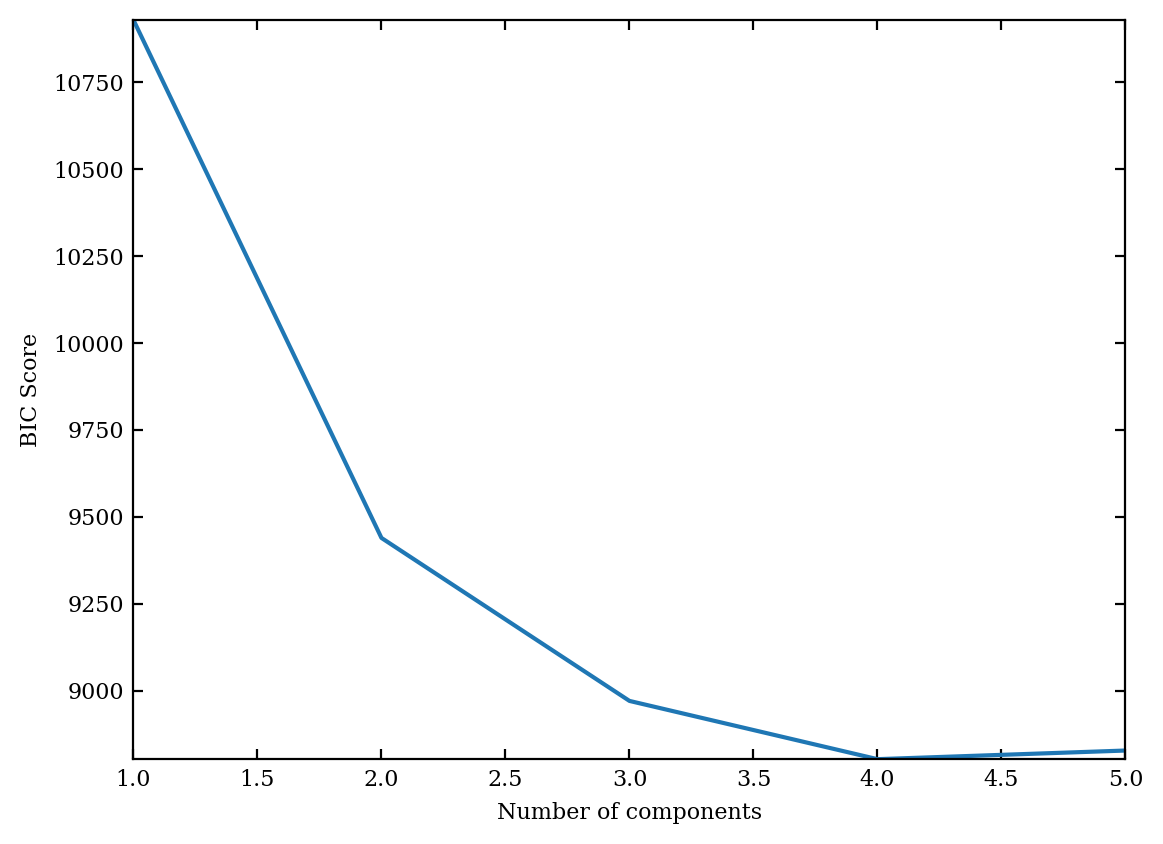

In [10]:
#optimal number according to the BIC
BIC = []
for ii in range(1,6):
    gmm = GaussianMixture(ii) #three components
    gmm.fit(x12)
    log_dens = gmm.score(x12)
    BIC.append(gmm.bic(x12))

plt.plot(np.arange(1,6), BIC);
plt.xlabel('Number of components');
plt.ylabel('BIC Score');
plt.show()

In [11]:
print("Index of the optimal number of components:",np.argmin(BIC))
print("Optimal number of components=",models[3])

Index of the optimal number of components: 3
Optimal number of components= GaussianMixture(n_components=4)


Fit the data set with this optimal number of GMM components, and create a new plot that shows the data set, the GMM component mean locations, and the $2$-sigma GMM component ellipses. *(Use the code below to help with plotting the ellipses.)*

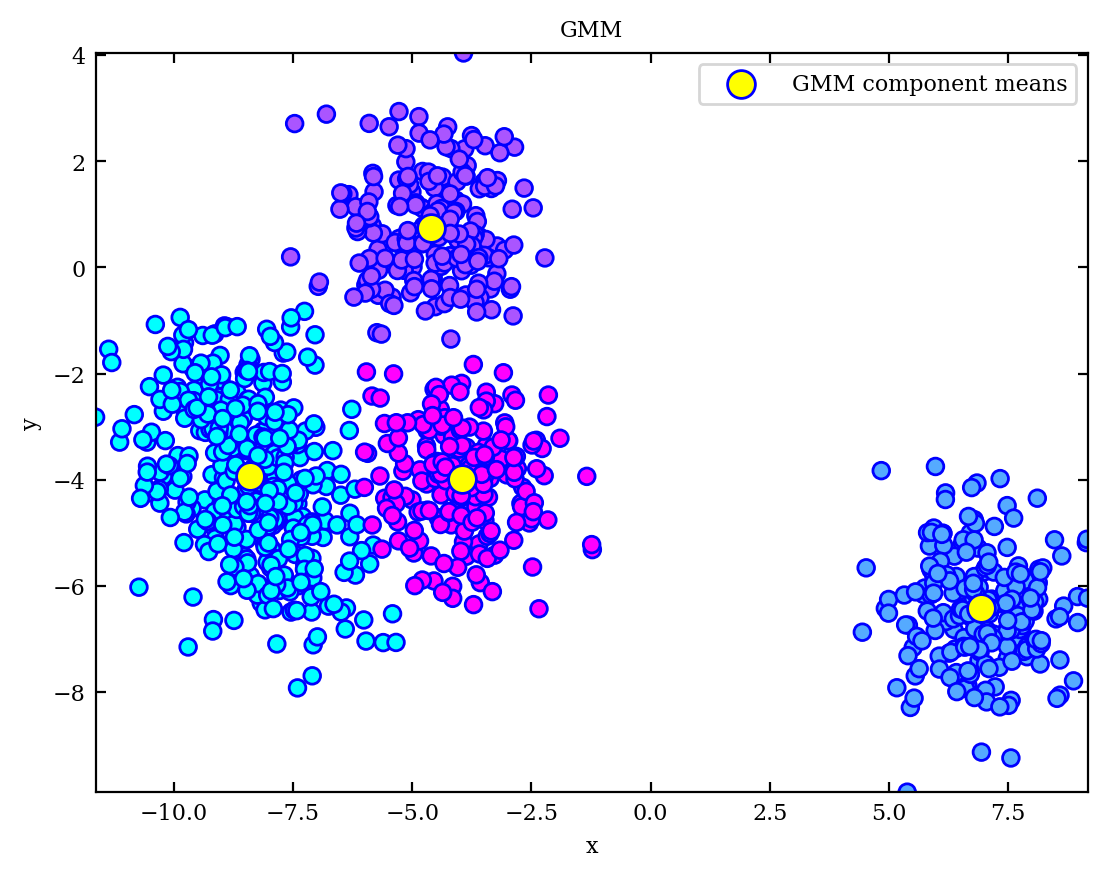

In [12]:
#fit the data set with 4 components
gmmfit = GaussianMixture(n_components=4)
gmmfit.fit(x12)

#plot the dataset
labels2 = gmmfit.predict(x12)
plt.scatter(x12[:,0],x12[:,1],c=labels2, cmap='cool')
plt.title('GMM')
plt.xlabel('x')
plt.ylabel('y')


#GMM mean component locations
means = gmmfit.means_
plt.scatter(means[:,0],means[:,1],marker='o',c='yellow', s=100, label='GMM component means')

plt.legend()
plt.show()

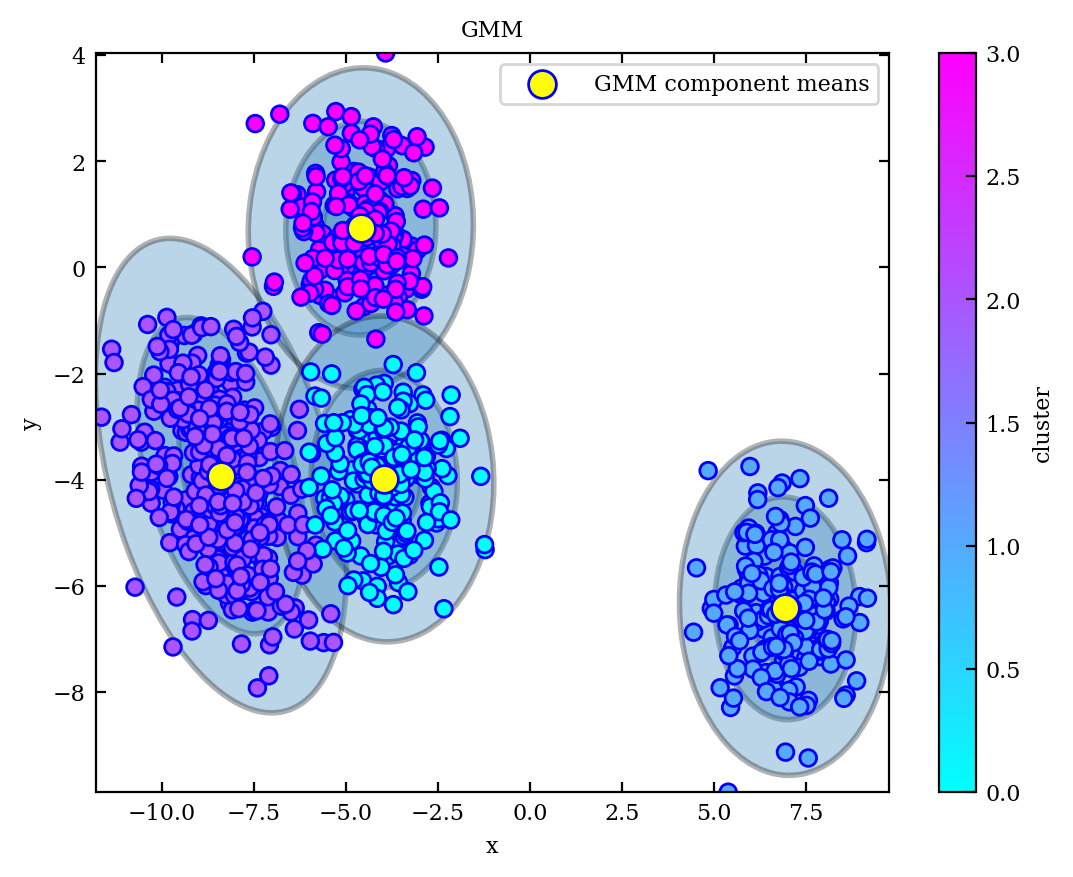

In [13]:


# Kludge to fix the bug with draw_ellipse in astroML
from matplotlib.patches import Ellipse

C = gmmfit.covariances_
mu = gmmfit.means_

def draw_ellipse(mu, C, scales=[1, 2, 3], ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    # find principal components and rotation angle of ellipse
    sigma_x2 = C[0, 0]
    sigma_y2 = C[1, 1]
    sigma_xy = C[0, 1]

    alpha = 0.5 * np.arctan2(2 * sigma_xy,
                          (sigma_x2 - sigma_y2))
    tmp1 = 0.5 * (sigma_x2 + sigma_y2)
    tmp2 = np.sqrt(0.25 * (sigma_x2 - sigma_y2) ** 2 + sigma_xy ** 2)

    sigma1 = np.sqrt(tmp1 + tmp2)
    sigma2 = np.sqrt(tmp1 - tmp2)

    for scale in scales:
        ax.add_patch(Ellipse(xy=(mu[0], mu[1]),
                          width=2 * scale * sigma1, height=2 * scale * sigma2,
                          angle=alpha * 180. / np.pi,
                          **kwargs))
        
for i in range(len(means)):
    draw_ellipse(mu[i],C[i],ax=plt.gca(), edgecolor='black', linestyle='-', lw=2,alpha=0.3)


gmmfit = GaussianMixture(n_components=4)
gmmfit.fit(x12)

#plot the dataset
labels2 = gmmfit.predict(x12)
plt.scatter(x12[:,0],x12[:,1],c=labels2, cmap='cool')
plt.title('GMM')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar(label='cluster')

#GMM mean component locations
means = gmmfit.means_
plt.scatter(means[:,0],means[:,1],marker='o',c='yellow', s=100, label='GMM component means')

plt.legend()
plt.show()

#### 1.5

In [14]:
#scale the data
from sklearn.cluster import KMeans
from sklearn import preprocessing

n_clusters = 5
scaler = preprocessing.StandardScaler()
kmeans = KMeans(n_clusters=n_clusters)
fit_kmeans = kmeans.fit(scaler.fit_transform(x12)) #fit Kmeans model 


/Users/toralcm/anaconda3/envs/astr8070/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [15]:
#cluster centers
cluster_centers = fit_kmeans.cluster_centers_
print("Location of cluster centers:",cluster_centers)

#inverse transform 
inverse_center = scaler.inverse_transform(cluster_centers)
print("Inverse transform of cluster centers:",inverse_center)

Location of cluster centers: [[-0.89111701  0.30903188]
 [ 1.85536514 -1.10846459]
 [-0.03983197 -0.12505393]
 [-0.16072001  1.62562286]
 [-0.69852349 -0.66523067]]
Inverse transform of cluster centers: [[-8.75119663 -2.68955747]
 [ 6.93608907 -6.42286837]
 [-3.88884877 -3.83282471]
 [-4.57933395  0.77799508]
 [-7.65114598 -5.25550743]]


In [16]:
#predict the labels for the scaled data
predictlabels = fit_kmeans.predict(scaler.fit_transform(x12))

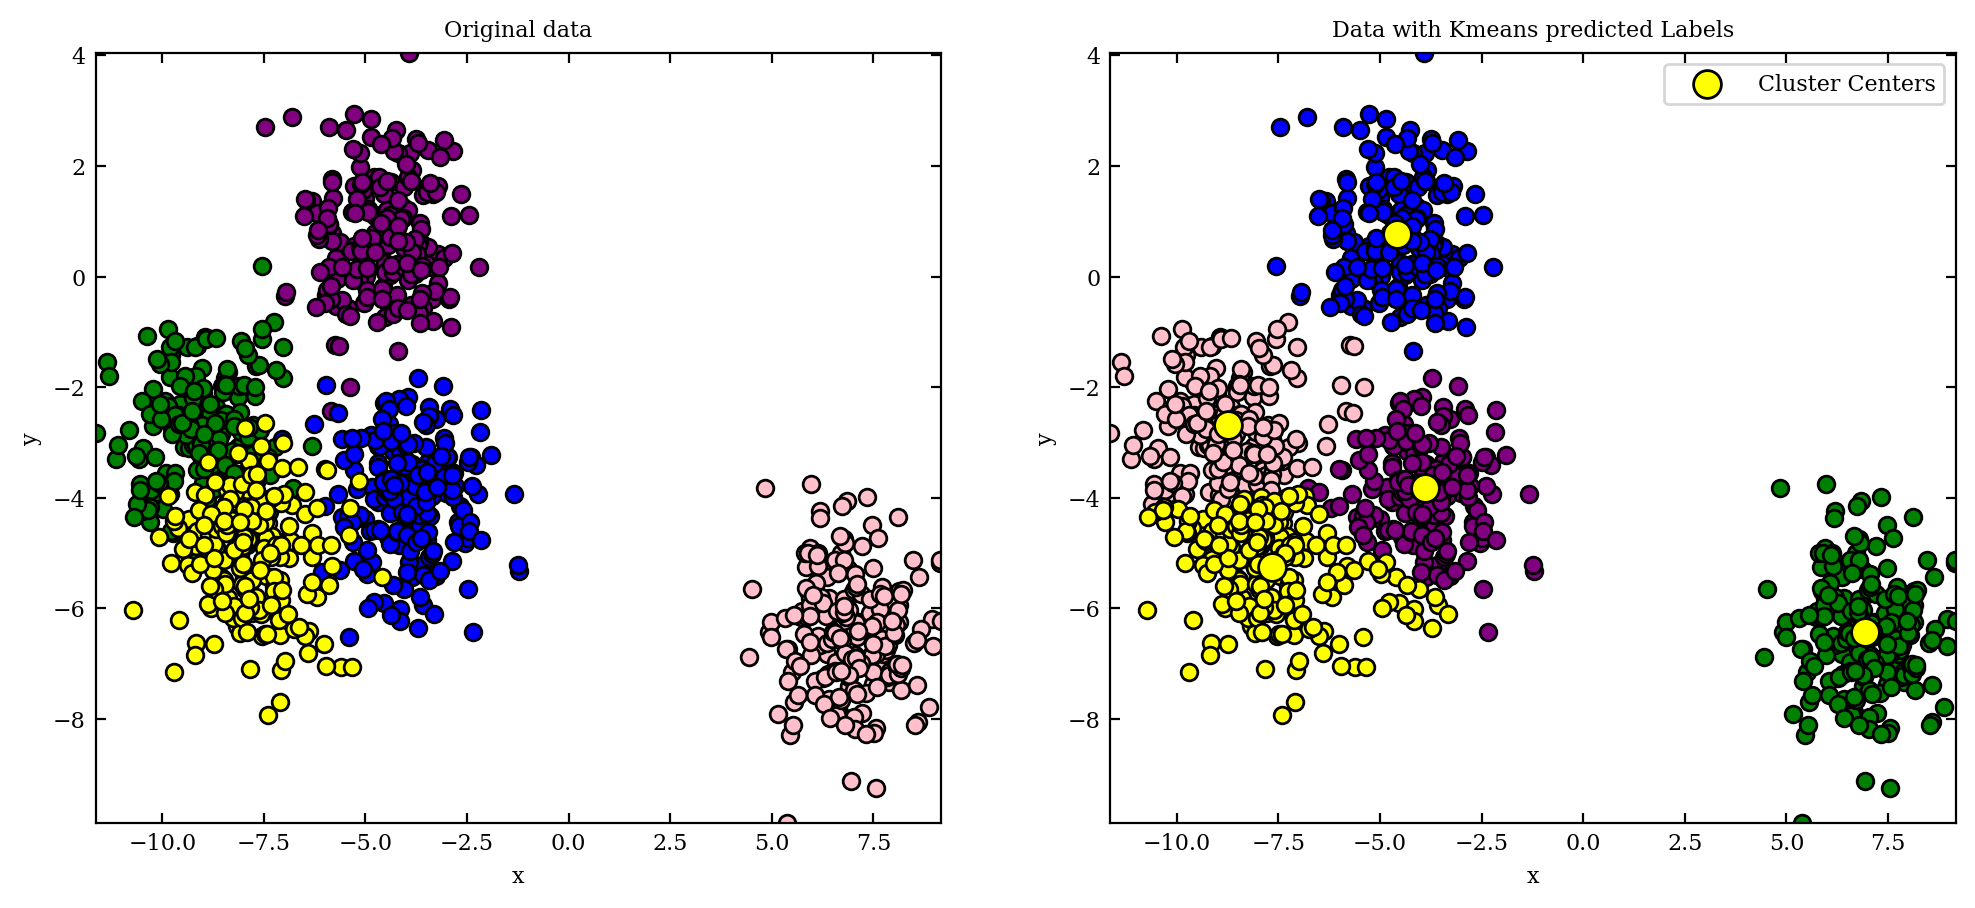

In [25]:
#plots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

labels=hw6_data[:,2]
colors = ['pink','green','purple','blue','yellow']
for ii in range(5):
    original_data = axs[0].scatter(hw6_data[labels==ii,0],hw6_data[labels==ii,1],c=colors[ii], edgecolor='black')

axs[0].set_title('Original data')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')

for ii in range(5):
    kmeans_data = axs[1].scatter(x12[predictlabels==ii, 0], x12[predictlabels==ii, 1],edgecolor='black',c=colors[ii])

axs[1].scatter(inverse_center[:, 0], inverse_center[:, 1], c='yellow', marker='o', s=100, label='Cluster Centers',edgecolor='black')

axs[1].set_title('Data with Kmeans predicted Labels')
axs[1].legend()
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')


plt.show()

SRT: Excellent work, Celia!!